In [1]:
library(zoo)
library(data.table)


Anexando pacote: 'zoo'


Os seguintes objetos são mascarados por 'package:base':

    as.Date, as.Date.numeric



Anexando pacote: 'data.table'


Os seguintes objetos são mascarados por 'package:zoo':

    yearmon, yearqtr




#### Limpeza dos dados
* dados ausentes
* upsamping e dowsampling
* suavização dos dados
* lidar com sazonalidade dos dados
* prevenir lookaheads não intencionais

In [2]:
unemp = fread('datasets/UNRATE.csv')

In [3]:
# Passando para data no R
unemp[,DATE:=as.Date(DATE)]

# definido a chave do dataframe
setkey(x = unemp, cols = DATE)

In [4]:
head( unemp, n = 2)

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-02-01,3.8


>Sim, é bem semelhante ao set_index do pandas em Python! Ambos são usados para definir colunas que servem como índices (ou chaves) para facilitar a ordenação e acelerar operações de busca e junções (joins).
>
> * No pandas: set_index é usado para definir uma ou mais colunas como índice do DataFrame.
> * No data.table (R): setkey serve para definir uma ou mais colunas como chave de um data.table, o que automaticamente ordena a tabela com base nessas colunas.

In [5]:
sample(1:10, 9, replace = TRUE)

[1] 9 4 4 9 3 5 4 4 1

In [6]:
# Gerando dados aleatoriamente ausentes

set.seed(seed = 1)
rand.unemp.idx = sample(1:nrow(unemp), .1*nrow(unemp))


rand.nan.unemp = unemp[-rand.unemp.idx]

In [7]:
# gera um conj. dados onde os dados possuem uma maior prob de ausencia quando é alto o desemprego

high.unemp.idx = which(unemp$UNRATE > 8)

num.to.select = .2 * length(high.unemp.idx)

high.unemp.idx = sample(high.unemp.idx, )

bias.unemp = unemp[-high.unemp.idx]

In [8]:
all.dates = seq(from = unemp$DATE[1], to = tail(unemp$DATE, 1), by='months')

In [9]:
rand.unemp = rand.nan.unemp[J(all.dates), roll=0]
bias.unemp = bias.unemp[J(all.dates), roll=0]

rand.unemp[, rpt := is.na(UNRATE)]

In [10]:
head( bias.unemp[is.na(UNRATE)],n = 2)

DATE,UNRATE
<date>,<dbl>
1975-01-01,NA
1975-02-01,NA


In [11]:
head( rand.unemp[is.na(UNRATE)],n = 2)

DATE,UNRATE,rpt
<date>,<dbl>,<lgl>
1949-10-01,NA,TRUE
1950-05-01,NA,TRUE


### Imputação

#### Forward Fill
* Ela transfere o útimo valor conhecido para o ausente 
    * ```r
        na.locf(VALOR, na.rm = FALSE)
    ```

In [12]:
vertor_ = c(1, NA, 2, 3, NA, NA, 5, 4, 2, NA)
vertor_

[1]  1 NA  2  3 NA NA  5  4  2 NA

In [13]:
na.locf(vertor_, na.rm = TRUE)

[1] 1 1 2 3 3 3 5 4 2 2

In [14]:
na.locf(vertor_, na.rm = FALSE)

[1] 1 1 2 3 3 3 5 4 2 2

In [15]:
# Forward fill

rand.unemp[, input.ff := na.locf(UNRATE,na.rm = FALSE)]
bias.unemp[, input.ff := na.locf(UNRATE,na.rm = FALSE)]

In [16]:
par(bg='white', cex.axis = 2)
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res=800)


unemp[350:400, 
        plot( DATE, UNRATE, col=1, lwd=2, type='b', pch=19 )
    ]
rand.unemp[
    350:400, 
        lines( DATE, input.ff, col=1, lwd=2, lty=2 )
    ]
rand.unemp[350:400][ rpt==TRUE, 
        points(DATE, input.ff, col=2, pch=19, cex=3)
    ]

NULL

NULL

NULL

> As bolinhas é onde os valores foram imputados

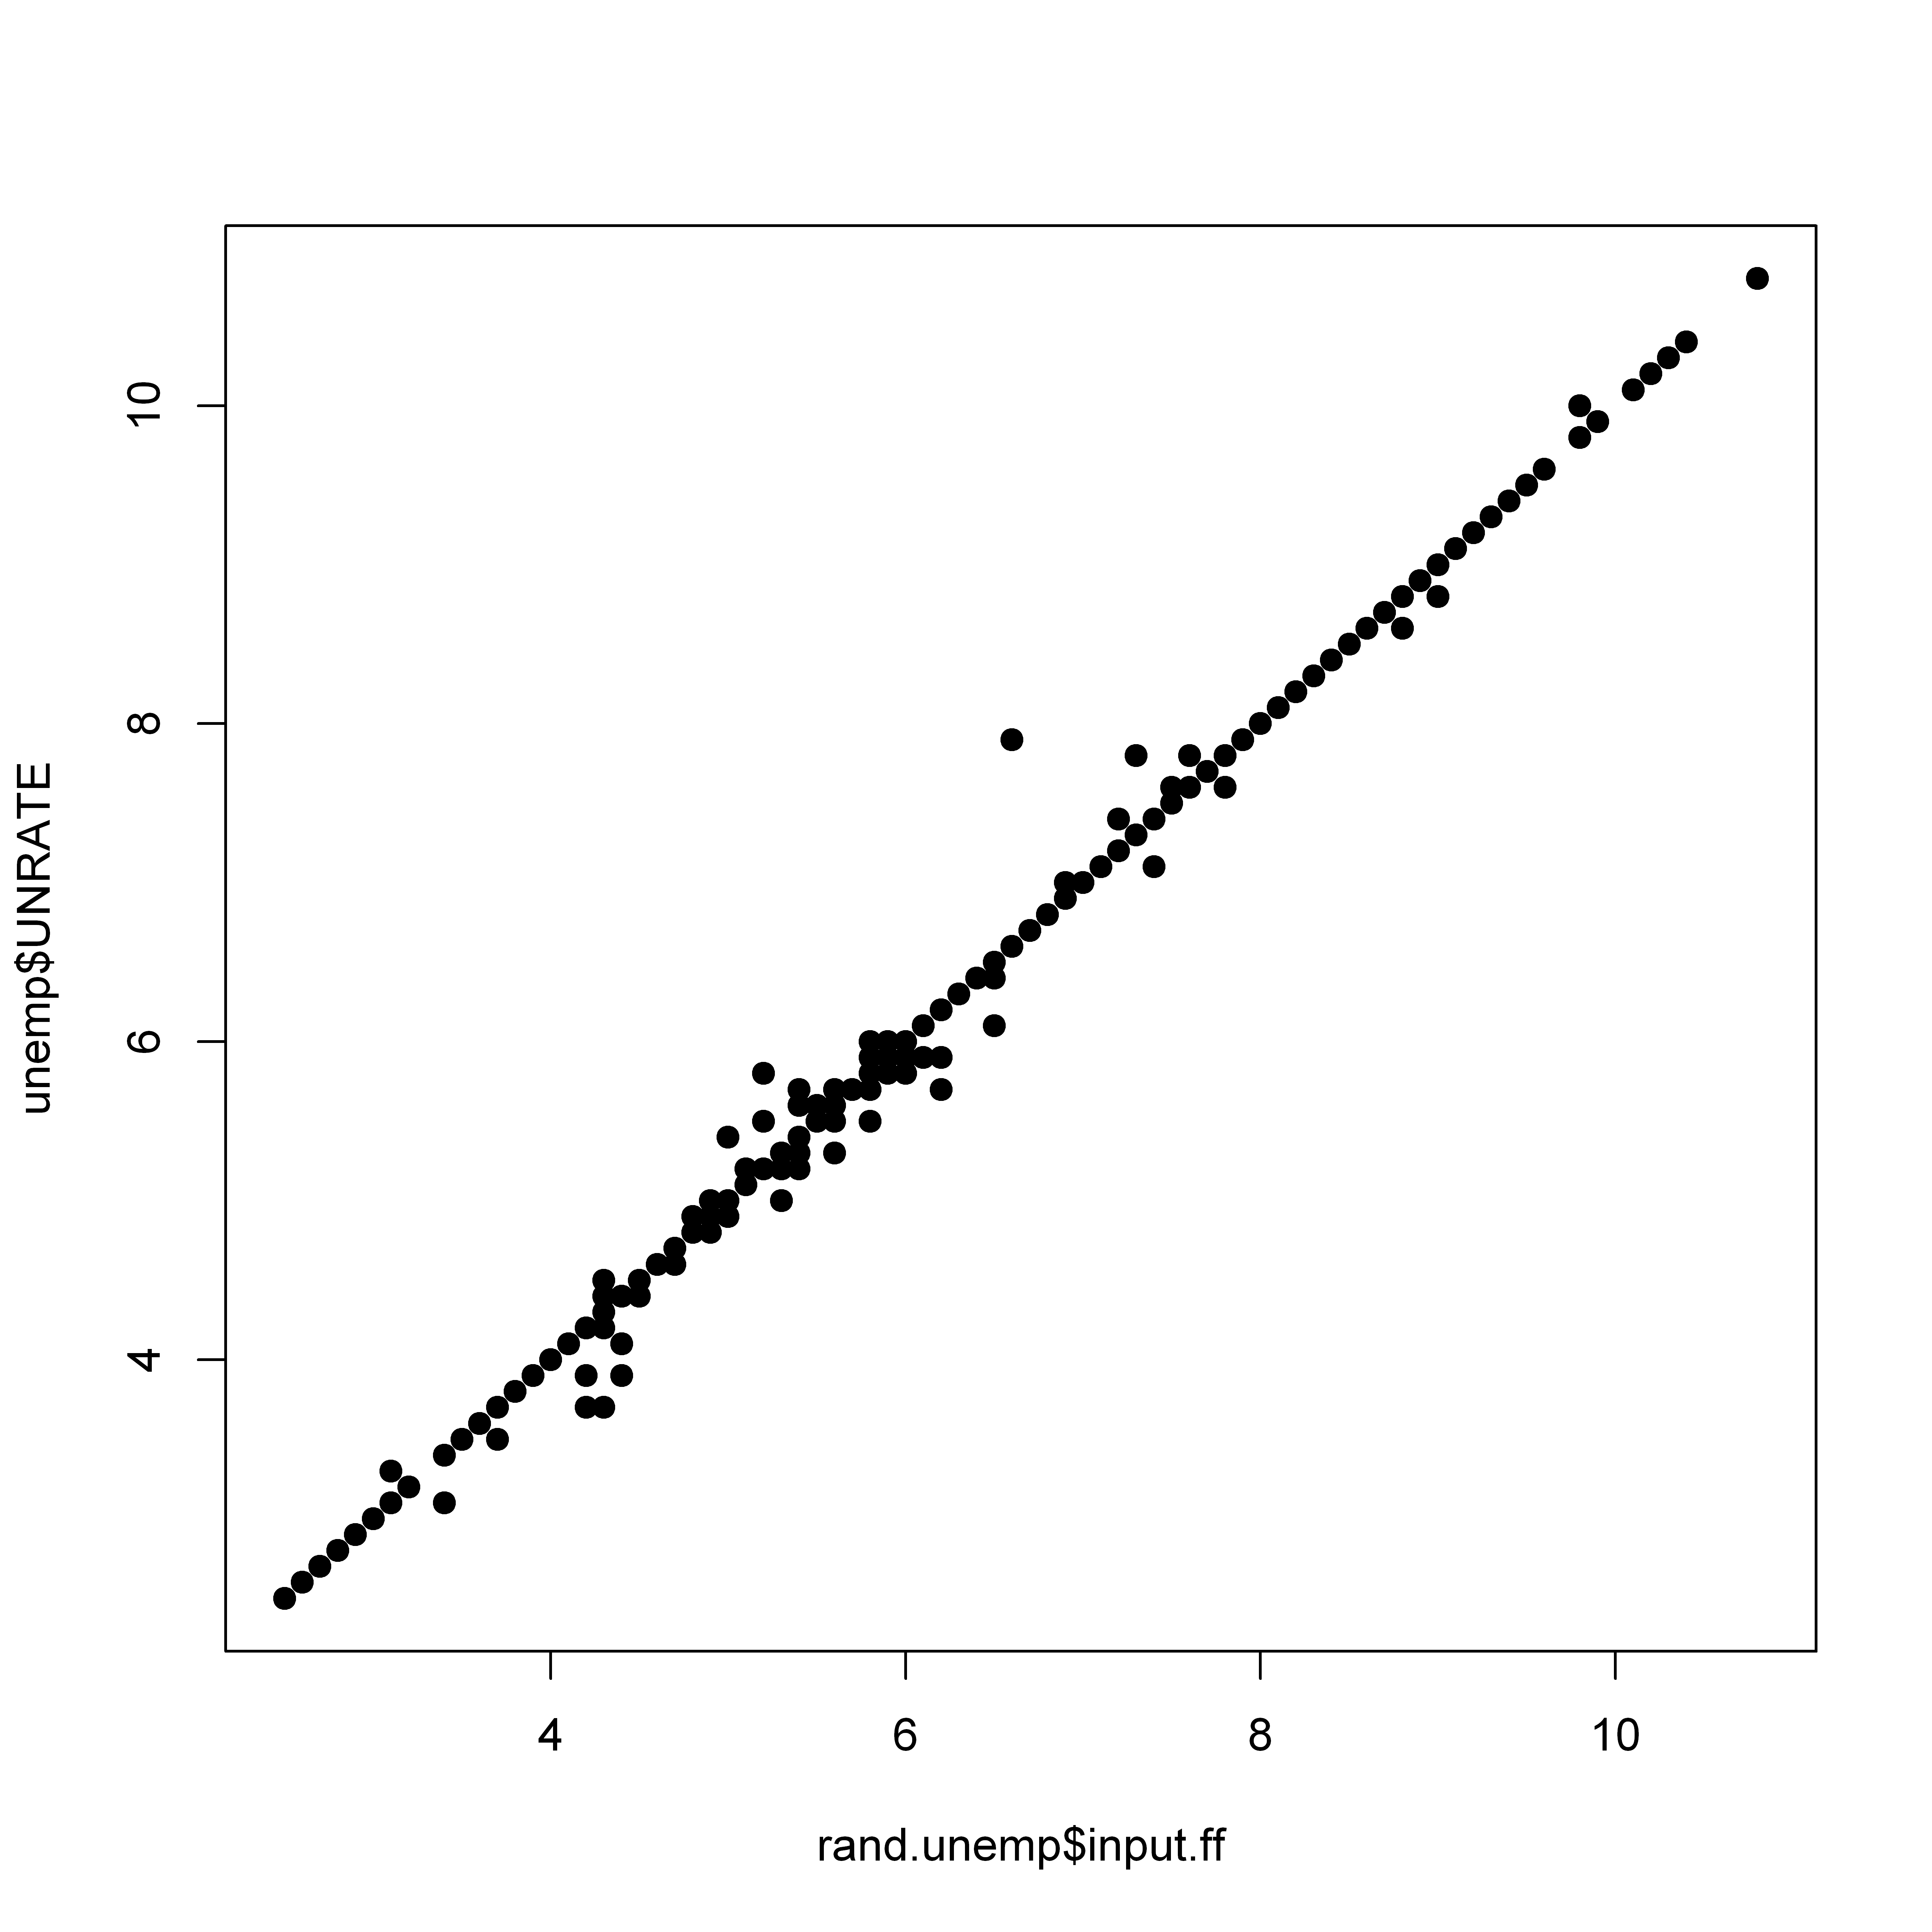

In [17]:
par(bg='white')
options(repr.plot.width = NULL, repr.plot.height = NULL)


plot(rand.unemp$input.ff, unemp$UNRATE, pch = 19)

> Plotamos a taxe de desemprego real x imputados. Esses gráfico mostra que ff não distorceus sistematicamente os dados

> **EM ALGUNS AMBIENTES FORWARD FILL é a melhor maneria de preencher dados ausentes mesmo que métodos "mais sofisticados" seja possíveis.**

&nbsp;

#### Média movel
* Semelhante ao forward fill mas aplicando a média móvel
* Em diversa situações em que uma imputação de dados de média móvel melhor se adequa a tarefa em questão do que um Forward Fill:
    * Dados forem muito ruidosos 

```r
rollapply(c(NA, NA, vertor_), 3, 
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)
```

In [18]:
vertor_

[1]  1 NA  2  3 NA NA  5  4  2 NA

In [19]:
rollapply(c(NA, NA, vertor_), 3, 
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)

[1] 1.0 1.0 2.0 3.0 2.5 3.0 5.0 4.0 2.0 3.0

In [20]:
# média movel sem lookhead
rand.unemp[, input.rn.nolookhead := rollapply(
    c(NA, NA, UNRATE), 3, 
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)]

In [21]:
# média movel sem lookhead
bias.unemp[, input.rn.nolookhead := rollapply(
    c(NA, NA, UNRATE), 3, 
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)]

**Média movéis com o lookhead**

In [22]:
vertor_

[1]  1 NA  2  3 NA NA  5  4  2 NA

In [23]:
rollapply(c(NA, vertor_, NA), 3, 
    function(x){
        if (!is.na(x[2])) x[2] else mean(x, na.rm=TRUE)
    }
)

[1] 1.0 1.5 2.0 3.0 3.0 5.0 5.0 4.0 2.0 2.0

> Não é apropriado caso estaja preparando seus dados para fornece-los a um modelo preditivo

In [24]:
rand.unemp[, input.rn.lookhead := rollapply(
    c(NA, UNRATE, NA), 3, 
    function(x){
        if (!is.na(x[2])) x[2] else mean(x, na.rm=TRUE)
    }
)]

In [25]:
bias.unemp[, input.rn.lookhead := rollapply(
    c(NA, UNRATE, NA), 3, 
    function(x){
        if (!is.na(x[2])) x[2] else mean(x, na.rm=TRUE)
    }
)]

In [26]:
par(bg='white')
options(repr.plot.width = 20, repr.plot.height = 10)


unemp[350:400, 
        plot( DATE, UNRATE, col=1, lwd=2, type='b', pch=19 )
    ]
rand.unemp[
    350:400, 
        lines( DATE, input.rn.nolookhead, col=1, lwd=2, lty=2 )
    ]
rand.unemp[350:400][ rpt==TRUE, 
        points(DATE, input.rn.nolookhead, col=2, pch=19, cex=3)
    ]

NULL

NULL

NULL

> **Reduz a variância no conj. dados. Seu cálculo pode superestimar o desempenho de seu modelo**

#### Interpolação

* Interpolação Linear possibilita que voce use seu conhecimento de como o sistema se comporta ao longo do tempo.
* Assim como a media movel voce pode imputar dados considerando o passado e futuro caso isso não represente um problema para sua tarefa, pois esta criando um lookhead

**linear**

```r
na.approx(variavel)
```

In [27]:
# Interpolação linear
rand.unemp[, input.li :=na.approx(UNRATE)]
bias.unemp[, input.li :=na.approx(UNRATE)]

**Polinimial**
```r
na.spline(variavel)
```

In [28]:
# Polinomial
rand.unemp[, input.sp := na.spline(UNRATE)]
bias.unemp[, input.sp := na.spline(UNRATE)]

In [29]:
use.id = 90:120

NULL

NULL

NULL

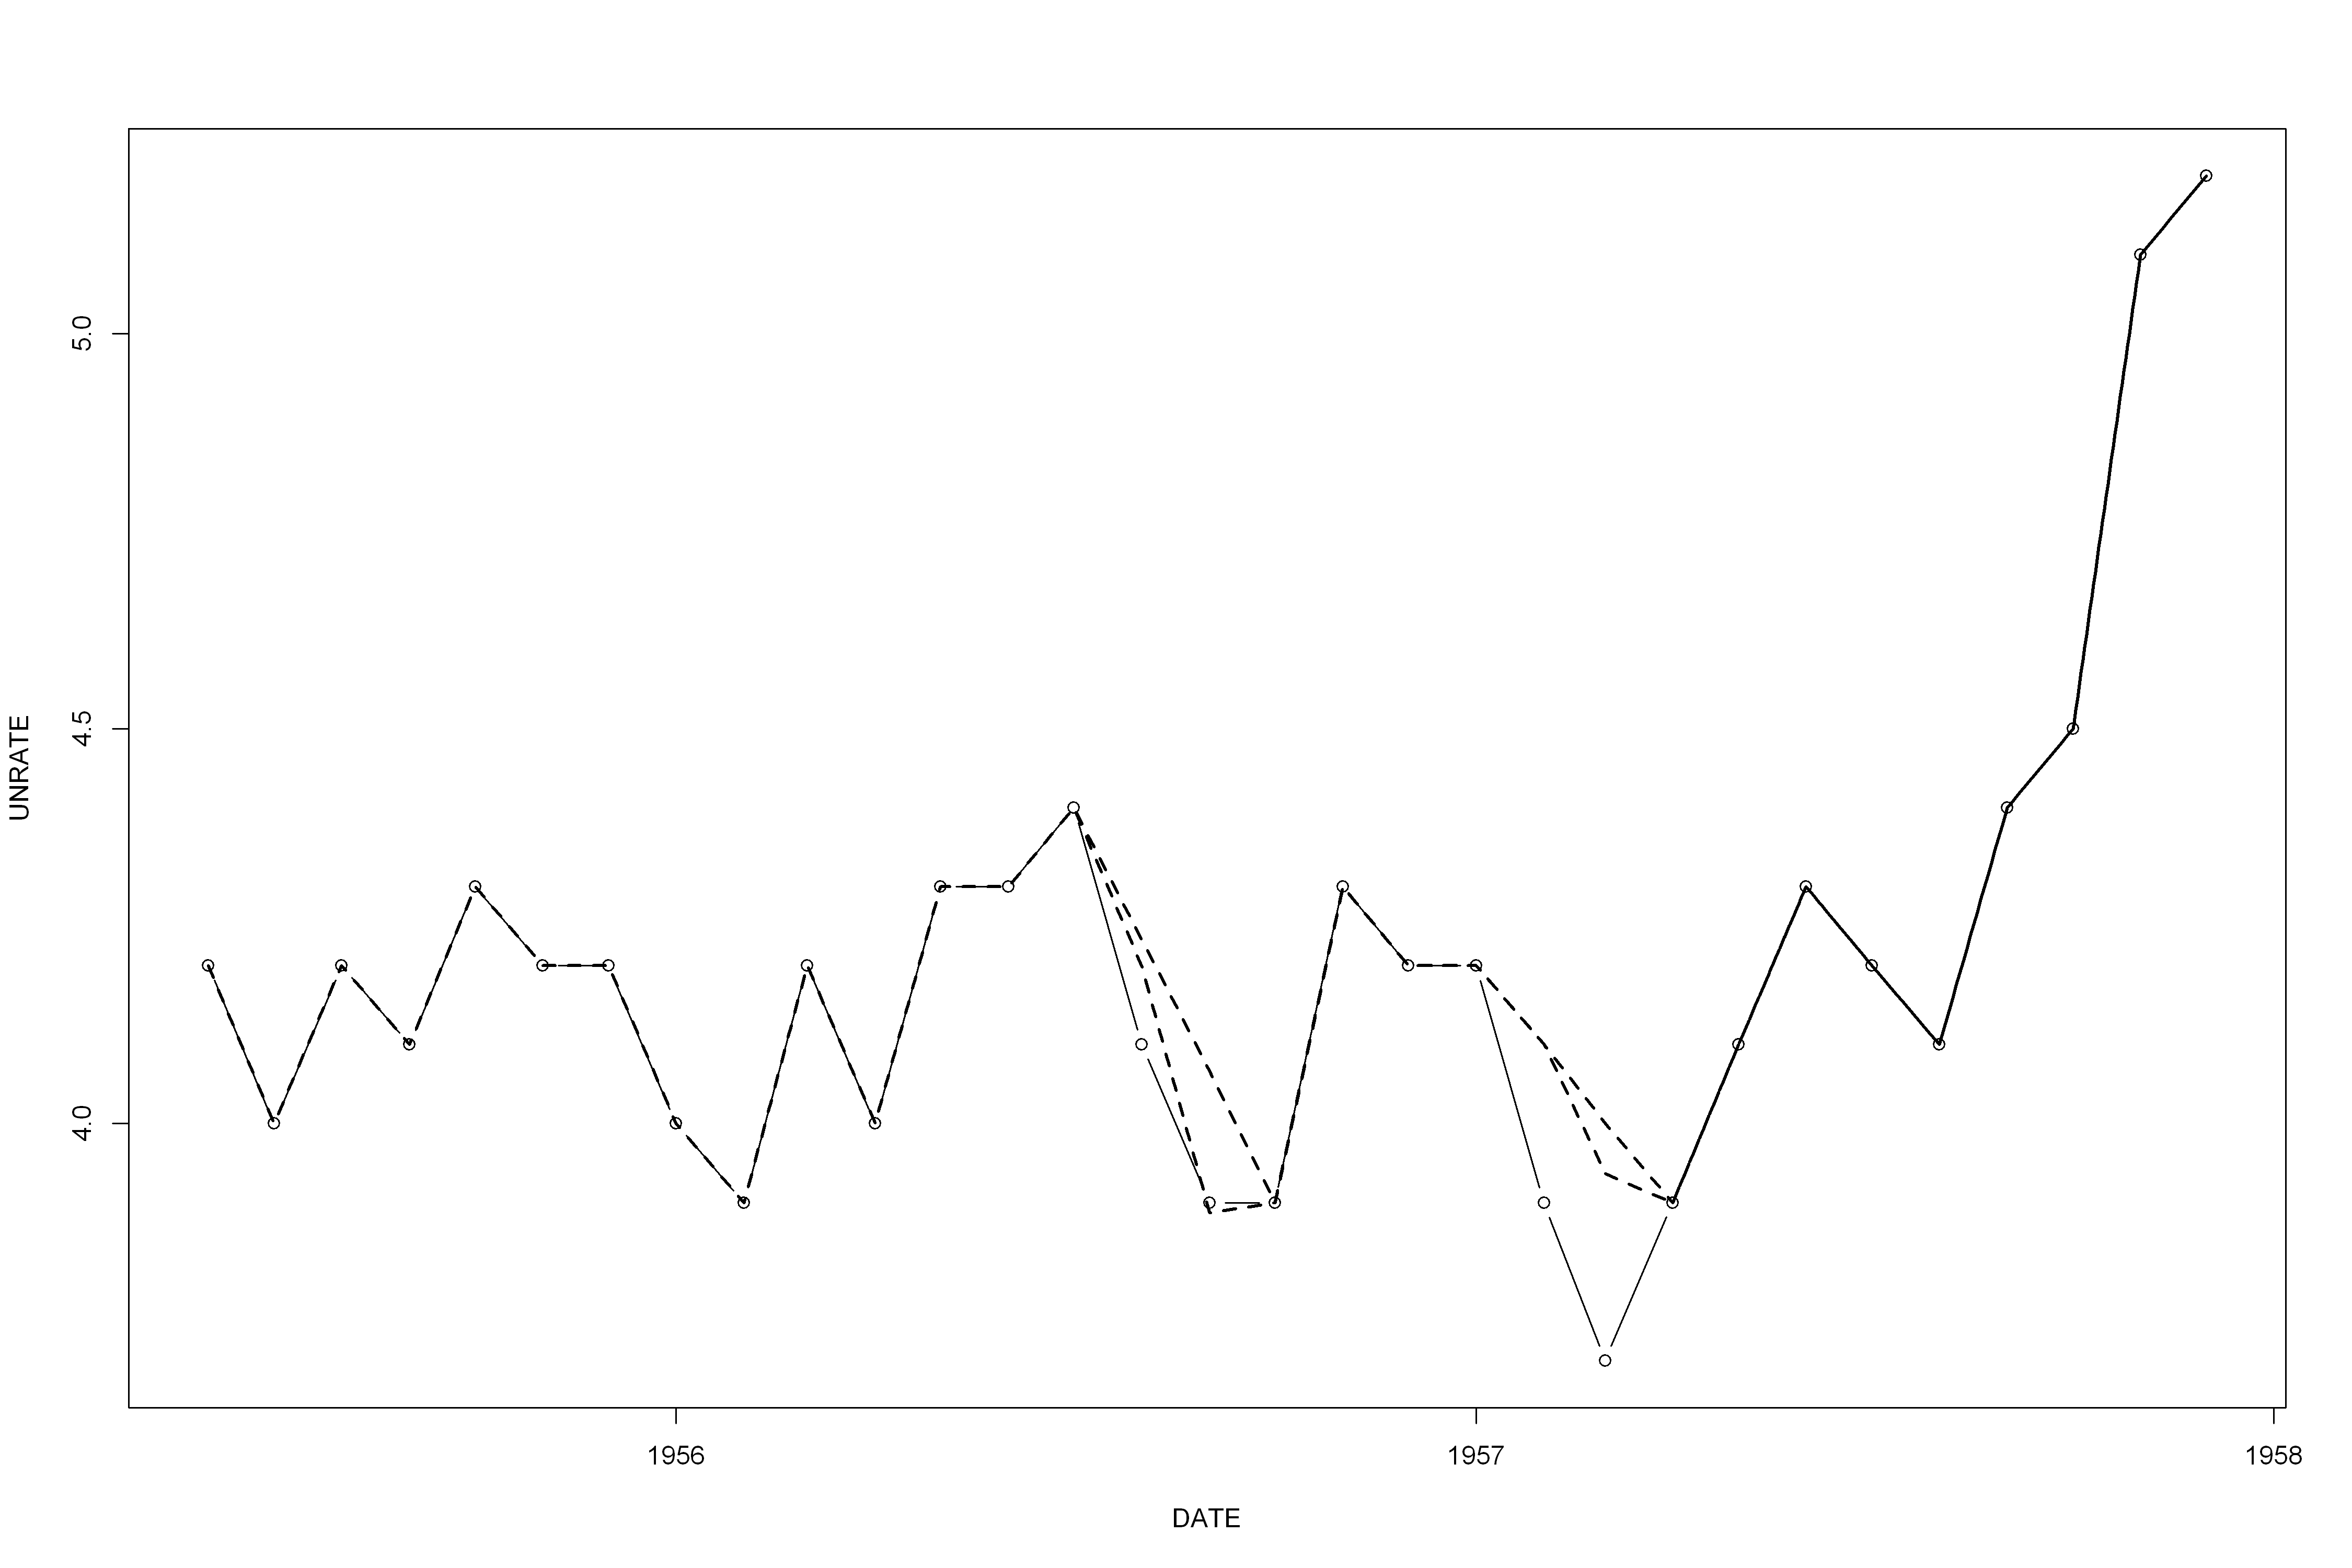

In [36]:
par(bg='white')
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 300)


unemp[use.id, plot(DATE, UNRATE, col = 1, type = 'b')]
rand.unemp[
    use.id, 
        lines( DATE, input.li, col=1, lwd=2, lty=2 )
    ]

rand.unemp[
    use.id, 
        lines( DATE, input.sp, col=1, lwd=2, lty=2 )
    ]


comparando modelos

In [ ]:

rand.unemp[, 
    lapply(.SD, function(x) mean((x-unemp$UNRATE)^2, na.rm = TRUE)),
    .SDcols = c("input.ff","input.rn.nolookhead",
                "input.rn.lookhead","input.li","input.sp")
]

input.ff,input.rn.nolookhead,input.rn.lookhead,input.li,input.sp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.006587678,0.007755042,0.003609134,0.003559275,0.004920252


In [39]:

bias.unemp[, 
    lapply(.SD, function(x) mean((x-unemp$UNRATE)^2, na.rm = TRUE)),
    .SDcols = c("input.ff","input.rn.nolookhead",
                "input.rn.lookhead","input.li","input.sp")
]

input.ff,input.rn.nolookhead,input.rn.lookhead,input.li,input.sp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2318483,0.005572172,0.001937581,0.2163562,0.02323485
